In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

(heating-rate-profile)=

# Heating rate profiles

In {ref}`heating-rate` we showed that the heating rate $Q_r$ (K/s) for a particular height in
the atmosphere was defined by:

$$
\begin{aligned}
\rho c_p \Delta z \frac{dT}{dt} &= \Delta E_n\\
Q_r = \frac{dT}{dt} &= \frac{1}{\rho c_p} \frac{\Delta E_n}{\Delta z} = \frac{1}{\rho c_p} \frac{dE_n}{dz}
\end{aligned}
$$

where $E_n$ was the net flux integrated over all wavelengths (positive downwards), and $\Delta E_n$ is
the net downward flux $(E_{ntop} - E_{nbot})$ across a layer of thickness $\Delta z$.

In this notebook we use the hydrostatic equation  from {ref}`hydro` and the flux equation
from {ref}`flux_schwartzchild` to find dT/dz as a function of height for an atmosphere with
containing an absorbing gas with a mixing ratio of $r_gas=0.01$ kg/kg and a mass absorption coefficient
averaged across all longwave wavelengths of $k=0.01$   $m^2/kg$.

## Integrate the atmospheric pressure, temperature and density

Recall equation {mat:numref}`hydro`:

$$
dp = -\rho g dz
$$

for a hydrostatic atmosphere, if we assume that dT/dz is constant with height, we can
build up an atmosphere one level at a time, but starting with know $p$, $\rho$ and $T$ at the
surface and using the values of $dT/dz$, $dp/dz$  to find $T$ and $p$ at the next level.  Once
we have those, we can use the ideal gas law to find the density $\rho$ and move up.

This is done in the cell below.

In [2]:
def hydrostat(T_surf,p_surf,dT_dz,delta_z,num_levels):
    """
       build a hydrostatic atmosphere by integrating the hydrostatic equation from the surface,
       using num_levels of constant thickness delta_z
       
       Parameters
       ----------
       
       T_surf: float
            surface temperature in K
       p_surf: float
            surface pressure in Pa
       dT_dz: ndarray
             rate of temperature change with height in K/m
       delta_z: float
             layer thickness in m
       num_levels: float
             number of levels in the atmosphere
       
       Returns
       -------
       
       Temp, press, rho, height: tuple of ndarrays of length num_levels
          where the surface is level 0, and each index i larger than 0
          is located at the height corresponding to the top of a particular layer,
          so that values at the top of the atmosphere are given by index
          numlevels - 1
       
          Temp (K) , press (Pa), rho (kg/m^3), height (m) for each layer
    """
    Rd=287. #J/kg/K  -- gas constant for dry air
    g=9.8  #m/s^2
    Temp=np.empty([num_levels])
    press=np.empty_like(Temp)
    rho=np.empty_like(Temp)
    height=np.empty_like(Temp)
    #
    # level 0 sits directly above the surface, so start
    # with pressure, temp of air equal to ground temp, press
    # and get density from equaiton of state
    #
    press[0]=p_surf
    Temp[0]=T_surf
    rho[0]=p_surf/(Rd*T_surf)
    height[0]=0
    num_layers=num_levels - 1
    #now march up the atmosphere a level at a time
    # finding the values at the top of each layer
    for i in range(num_layers):
        delP= -rho[i]*g*delta_z
        height[i+1] = height[i] + delta_z
        Temp[i+1] = Temp[i] + dT_dz[i]*delta_z
        press[i+1]= press[i] + delP
        rho[i+1]=press[i+1]/(Rd*Temp[i+1])
    return (Temp,press,rho,height)

## Next we can find the optical depth 

If we have the air density $\rho$, the mixing ratio $r_{mix}$ asnd  the absorption coefficient $k$ from Stull Chapter 2
section 2.3.6 we can find the optical depth in the layer:

$$
\tau = \rho r_{mix} k \Delta z
$$

where $\Delta z$ is the layer thickness.  That's done in the next cell.

In [3]:
def find_tau(r_gas,k,rho,height):
    """
       Parameters
       ----------
       
       r_gas: float
           gas mixing ratio in kg/kg
       k: float
           mass absorption coefficient in kg/m^2
       rho: ndarray
           vector of air densities in kg/m^3 for each layer
       height: ndarray
        corresponding level heights in m
        
       Returns
       -------
       
          tau: ndarray 
             vertical optical depths of each level, starting from 0 at the surface
    """
    tau=np.empty_like(rho)
    tau[0]=0
    num_levels=len(rho)
    num_layers=num_levels - 1
    for index in range(num_layers):
        delta_z=height[index+1] - height[index]
        delta_tau=r_gas*rho[index]*k*delta_z
        tau[index+1]=tau[index] + delta_tau
    return tau

## Flux with height

Note the factor of 1.666 below that multiplies the optical depth in
the transmission -- this is the flux diffusivity approximation.  The function below
solves for the upward and downward fluxes one layer at at time by calculating
the transmitted flux arriving from the bottom or the top of each layer, and the
emitted flux that the layer is sending to the next layer above or below using the equation given in
{math:numref}`layer_flux`. This is the
"two stream approximation" mentioned in {ref}`two-stream-approx`

Assumption:  layers are thin enough so that it is safe to assume constant values
within each layer

In [4]:
def fluxes(tau,Temp,height,T_surf):
    """
    given properties at each level return the upward and downward
    total flux at each level assuming no downward longwave flux at the top
    of the atmosphere, and a surface flux of sigma*T_surf**4.
    
    Parameters
    -----------
    
    tau, Temp, height:  ndarray of length tot_levels
        total optical depth (from surface), temperature (K) and height (m)
        at each level
        
    Returns
    -------
    
    up_flux, down_flux: ndarrays
       upward and downward flux of each level (W/m^2), all positive
    
    """
    sigma=5.67e-8 #W/m^2/K^4
    up_flux=np.empty_like(height)
    down_flux=np.empty_like(height)
    sfc_flux=sigma*T_surf**4.
    up_flux[0]=sfc_flux
    tot_levs=len(tau)
    for index in np.arange(1,tot_levs):
        upper_lev=index
        lower_lev=index - 1
        del_tau=tau[upper_lev] - tau[lower_lev]
        trans=np.exp(-del_tau)
        emiss=1 - trans
        layer_flux=sigma*Temp[lower_lev]**4.*emiss
        #
        # find the flux at the next level
        #
        up_flux[upper_lev]=trans*up_flux[lower_lev] + layer_flux
    #
    # start at the top of the atmosphere
    # with zero downwelling flux
    #
    down_flux[tot_levs-1]=0
    #
    # go down a level at a time, adding up the fluxes
    #
    for index in np.arange(1,tot_levs):
        upper_lev=tot_levs - index
        lower_lev=tot_levs - index -1
        del_tau=tau[upper_lev] - tau[lower_lev]
        trans=np.exp(-1.666*del_tau)
        emiss=1 - trans
        layer_flux=sigma*Temp[upper_lev]**4.*emiss
        down_flux[lower_lev]=down_flux[upper_lev]*trans + layer_flux
    return (up_flux,down_flux)

In [5]:
def heating_rate(net_down,height,rho):
    """
    given the net flux at each level (downward positive) and the
    height, and density of the atmosphere at each level, return
    the rate of change of temperature in each layer between two levels
    
    Parameters
    ----------
    
    net_down: ndarray
       positive downward net flux (W/m^2) at each level
       
    height: ndarray
       vertical location of each level (m)
       
    rho: ndarray
       density (kg/m^3) at each level
    
    Returns
    -------
    
    dT_dz: ndarray  -- length nlevels -1
       vector of temperature gradients across each layer (K/m)
       
    
    """
    
    cpd=1004.
    #
    # find the flux divergence across the layer
    # by differencing the levels.  Assume the layer density is constant
    # and equal to the average of the densities at the top and bottom levels
    #
    rho_mid=(rho[1:] + rho[:-1])/2.
    dEn_dz= np.diff(net_down)/np.diff(height)
    dT_dz=dEn_dz/(rho_mid*cpd)
    return dT_dz

In [6]:
def main():
    """
    find the heating rate (K/km) for a hydrostatic
    atmosphere with a constant decrease of temperature with heigt
    """
    
    #
    # use 15000 1 m thick layers from 0 to 15 km
    #
    r_gas=0.01  #kg/kg
    k=0.01  #m^2/kg
    T_surf=300 #K
    p_surf=100.e3 #Pa
    delta_z=1  #m
    num_levels=15000
    dT_dz = np.ones([num_levels])*(-7.e-3)
    #
    #
    #
    Temp,press,rho,height=hydrostat(T_surf,p_surf,dT_dz,delta_z,num_levels)
    tau=find_tau(r_gas,k,rho,height)
    up,down=fluxes(tau,Temp,height,T_surf)
    net_down = down - up
    dT_dt=heating_rate(down - up,height,rho)

    fig,(axis1,axis2,axis3)=plt.subplots(1,3,figsize=(15,10))
    axis1.plot(up,height*0.001,'b-',lw=5,label='upward flux')
    axis1.plot(down,height*0.001,'g-',lw=5,label='downward flux')
    axis1.set_title('upward and downward fluxes')
    axis1.set_xlabel('flux $(W\,m^{-2}$')
    axis1.set_ylabel('height (km)')
    axis1.legend(numpoints=1,loc='best')
    axis1.grid(True)

   
    axis2.plot(net_down,height*0.001,'b-',lw=5)
    axis2.set_title('net downward flux')
    axis2.set_xlabel('net downward flux $(W\,m^{-2})$')
    axis2.set_ylabel('height (km)')
    axis2.grid(True)


    dT_dt=dT_dt*3600.
    mid_height=(height[1:] + height[:-1])/2.
    axis3.plot(dT_dt,mid_height*0.001,'b-',lw=5)
    axis3.set_title('heating rate')
    axis3.set_xlabel('heating rate in K/hr')
    axis3.set_ylabel('height (km)')
    axis3.grid(True)

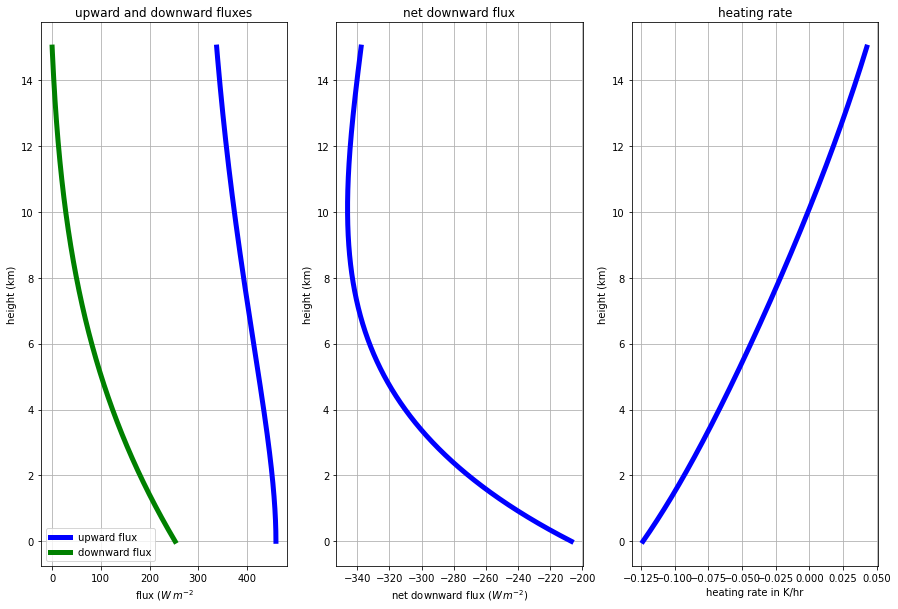

In [7]:
main()